In [ ]:
# dependencies:
#   - python=3.7
#   - numpy=1.19.1
#   - pandas=1.1.2
#   - matplotlib=3.3.2
#   - networkx=2.5
#   - pytorch=1.6.0
#   - pip
#   - pip:
#       - torch-geometric==1.6.1
#       - torch-scatter==2.0.5
#       - torch-sparse==0.6.7
#       - torch-cluster==1.5.7
#       - torch-spline-conv==1.2.0

# mamba install python=3.10 numpy pandas matplotlib networkx pytorch ipykernel ipywidgets jupyter tqdm -c conda-forge
# pip install torch-geometric   

In [3]:
import sys
sys.path.append('..')
import torch
import pandas as pd
import numpy as np
import pickle
import argparse
import networkx as nx
from collections import Counter
from torch_geometric.utils import dense_to_sparse, degree
import matplotlib.pyplot as plt
from src.gcn import GCNSynthetic
from src.utils.utils import normalize_adj, get_neighbourhood

### Syn1 dataset (BA houses) , best params so far: SGD + momentum=0.9, epochs=500, LR=0.1, beta=0.5

#### Uses correct version of symmetry constraint

#### For BA houses, class 0 = BA, class 1 = middle, class 2 = bottom, class 3 = top

In [4]:
header = ["node_idx", "new_idx", "cf_adj", "sub_adj", "y_pred_orig", "y_pred_new", "y_pred_new_actual",
            "label", "num_nodes", "loss_total", "loss_pred", "loss_graph_dist"]

In [5]:
# For original model
dataset = "syn1"
hidden = 20
seed = 42
dropout = 0.0

# Load original dataset and model

with open("../data/gnn_explainer/{}.pickle".format(dataset), "rb") as f:
	data = pickle.load(f)

adj = torch.Tensor(data["adj"]).squeeze()       # Does not include self loops
features = torch.Tensor(data["feat"]).squeeze()
labels = torch.tensor(data["labels"]).squeeze()
idx_train = torch.tensor(data["train_idx"])
idx_test = torch.tensor(data["test_idx"])
edge_index = dense_to_sparse(adj)

norm_adj = normalize_adj(adj)

model = GCNSynthetic(nfeat=features.shape[1], nhid=hidden, nout=hidden,
                     nclass=len(labels.unique()), dropout=dropout)
model.load_state_dict(torch.load("../models/gcn_3layer_{}.pt".format(dataset)))
model.eval()
output = model(features, norm_adj)
y_pred_orig = torch.argmax(output, dim=1)
print("test set y_true counts: {}".format(np.unique(labels[idx_test].numpy(), return_counts=True)))
print("test set y_pred_orig counts: {}".format(np.unique(y_pred_orig[idx_test].numpy(), return_counts=True)))
print("Whole graph counts: {}".format(np.unique(labels.numpy(), return_counts=True)))

test set y_true counts: (array([0, 1, 2, 3]), array([62, 29, 32, 17]))
test set y_pred_orig counts: (array([0, 1, 2, 3]), array([62, 30, 30, 18]))
Whole graph counts: (array([0, 1, 2, 3]), array([300, 160, 160,  80]))


In [6]:
lr = 0.1
beta = 0.5
num_epochs = 500
mom = 0.9

# Load cf examples for test set
with open("../results/{}/SGD/{}_cf_examples_lr{}_beta{}_mom{}_epochs{}_seed{}".format(dataset,
                                                                     dataset, lr, beta, mom, num_epochs, seed), "rb") as f:
    cf_examples = pickle.load(f)
    
df_prep = []
for example in cf_examples:
    if example != []:
        df_prep.append(example[0])
df = pd.DataFrame(df_prep, columns=header)
print("Num cf examples found for best nesterov: {}/{}".format(len(df), len(idx_test)))
print("Average graph distance for best nesterov: {}".format(np.mean(df["loss_graph_dist"])))

Num cf examples found for best nesterov: 85/140
Average graph distance for best nesterov: 2.388235294117647


In [14]:
# Add num edges to df

num_edges = []
for i in df.index:
    num_edges.append(sum(sum(df["sub_adj"][i]))/2)

df["num_edges"] = num_edges

### FINAL NUMBERS

In [15]:
print("Num cf examples found: {}/{}".format(len(df), len(idx_test)))
print("Coverage: {}".format(len(df)/len(idx_test)))
print("Average graph distance: {}".format(np.mean(df["loss_graph_dist"])))
print("Average prop comp graph perturbed: {}".format(np.mean(df["loss_graph_dist"]/df["num_edges"])))

Num cf examples found: 85/140
Coverage: 0.6071428571428571
Average graph distance: 2.388235294117647
Average prop comp graph perturbed: 0.002328509637811983


Text(0, 0.5, 'Prop CF examples')

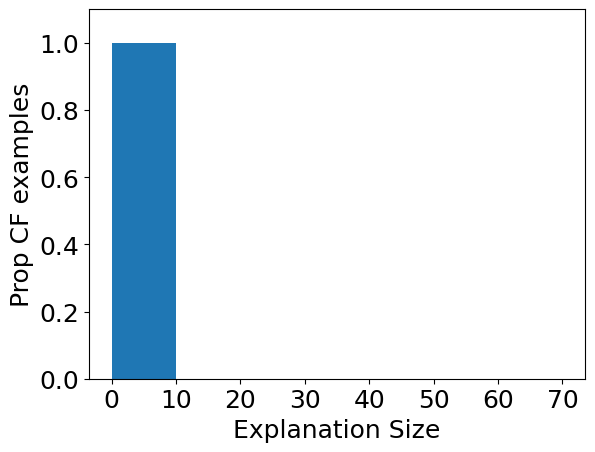

In [16]:

font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot graph loss of cf examples
bins = [i+0.5 for i in range(11)]
# bins=[0, 20, 40, 60]

bins = [0, 10, 20, 30, 40, 50, 60, 70]
plt.hist(df["loss_graph_dist"], bins=bins, weights=np.ones(len(df))/len(df))
# plt.title("BA-SHAPES")
plt.xlabel("Explanation Size")
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70])
plt.ylim(0, 1.1)
plt.ylabel("Prop CF examples")


In [8]:
# For accuracy, only look at motif nodes

df_motif = df[df["y_pred_orig"] != 0].reset_index(drop=True)

accuracy = []

# Get original predictions 
dict_ypred_orig = dict(zip(sorted(np.concatenate((idx_train.numpy(), idx_test.numpy()))), 
                           y_pred_orig.numpy()))

for i in range(len(df_motif)):
    node_idx = df_motif["node_idx"][i]
    new_idx = df_motif["new_idx"][i]

    _, _, _, node_dict = get_neighbourhood(int(node_idx), edge_index, 4, features, labels)

    # Confirm idx mapping is correct
    if node_dict[node_idx] == df_motif["new_idx"][i]:

        cf_adj = df_motif["cf_adj"][i]
        sub_adj = df_motif["sub_adj"][i]
        perturb = np.abs(cf_adj - sub_adj)
        perturb_edges = np.nonzero(perturb)        # Edge indices

        nodes_involved = np.unique(np.concatenate((perturb_edges[0], perturb_edges[1]), axis=0))
        perturb_nodes = nodes_involved[nodes_involved != new_idx]   # Remove original node

        # Retrieve original node idxs for original predictions
        perturb_nodes_orig_idx = []
        for j in perturb_nodes:
            perturb_nodes_orig_idx.append([key for (key, value) in node_dict.items() if value == j])
        perturb_nodes_orig_idx = np.array(perturb_nodes_orig_idx).flatten()

        # Retrieve original predictions
        perturb_nodes_orig_ypred = np.array([dict_ypred_orig[k] for k in perturb_nodes_orig_idx])
        nodes_in_motif = perturb_nodes_orig_ypred[perturb_nodes_orig_ypred != 0]
        prop_correct = len(nodes_in_motif)/len(perturb_nodes_orig_idx)

        accuracy.append([node_idx, new_idx, perturb_nodes_orig_idx, 
                        perturb_nodes_orig_ypred, nodes_in_motif, prop_correct])

df_accuracy = pd.DataFrame(accuracy, columns=["node_idx", "new_idx", "perturb_nodes_orig_idx", 
                        "perturb_nodes_orig_ypred", "nodes_in_motif", "prop_correct"])



print("Accuracy", np.mean(df_accuracy["prop_correct"]))

Accuracy 0.9591836734693877


In [20]:
# import sys
# sys.path.append('..')

from src.cf_explanation.cf_explainer import CFExplainer
from src.utils.utils import normalize_adj, get_neighbourhood

# 1) pick a node from test set
node_idx = int(idx_test[25])   # or any idx_test[k]
print("node_idx:", node_idx, "orig pred:", int(y_pred_orig[node_idx]), "true:", int(labels[node_idx]))

# 2) extract subgraph (same as main_explain.py)
sub_adj, sub_feat, sub_labels, node_dict = get_neighbourhood(
    node_idx, edge_index, 4, features, labels   # 4 = n_layers+1 for 3-layer GCN
)
new_idx = node_dict[node_idx]

# 3) sanity: full-graph vs subgraph prediction should match
with torch.no_grad():
    full_logits = output[node_idx]
    sub_logits  = model(sub_feat, normalize_adj(sub_adj))[new_idx]
print("full pred:", int(torch.argmax(full_logits)), "sub pred:", int(torch.argmax(sub_logits)))

# 4) run CF explainer for this one node
explainer = CFExplainer(
    model=model,
    sub_adj=sub_adj,
    sub_feat=sub_feat,
    n_hid=20,
    dropout=0.0,
    sub_labels=sub_labels,
    y_pred_orig=y_pred_orig[node_idx],
    num_classes=int(len(labels.unique())),
    beta=0.5,
    device=torch.device("cpu"),
)

cf_list = explainer.explain(
    cf_optimizer="SGD",
    node_idx=torch.tensor(node_idx),
    new_idx=new_idx,
    lr=0.005,
    n_momentum=0.0,
    num_epochs=500
)

print("num CF candidates returned:", len(cf_list))
best = cf_list[-1] if len(cf_list) else None
best

node_idx: 218 orig pred: 0 true: 0
full pred: 0 sub pred: 0
orig model requires_grad:  gc1.weight True
orig model requires_grad:  gc1.bias True
orig model requires_grad:  gc2.weight True
orig model requires_grad:  gc2.bias True
orig model requires_grad:  gc3.weight True
orig model requires_grad:  gc3.bias True
orig model requires_grad:  lin.weight True
orig model requires_grad:  lin.bias True
cf model requires_grad:  P_vec True
cf model requires_grad:  gc1.weight False
cf model requires_grad:  gc1.bias False
cf model requires_grad:  gc2.weight False
cf model requires_grad:  gc2.bias False
cf model requires_grad:  gc3.weight False
cf model requires_grad:  gc3.bias False
cf model requires_grad:  lin.weight False
cf model requires_grad:  lin.bias False
Node idx: 218 New idx: 218 Epoch: 0001 loss: -0.2670 pred loss: -0.2670 graph loss: 0.0000
Output: tensor([-0.2670, -8.5748, -8.1213, -1.4531])
 Output nondiff: tensor([ -0.1037, -10.4631, -10.3195,  -2.3183])
 orig pred: 0, new pred: 0, ne

[218,
 218,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(418, 418), dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(418, 418), dtype=float32),
 0,
 3,
 3,
 array(0),
 418,
 0.5,
 -1.0805946588516235,
 1.0]

In [17]:
def print_cf_example(best, node_dict=None, max_edges=10):
    """
    Pretty-print a CF-GNNExplainer counterfactual example.

    Parameters
    ----------
    best : list
        A single cf_example (usually best_cf_example[-1])
    node_dict : dict or None
        Mapping {orig_node_idx -> subgraph_idx}.
        If provided, will map subgraph nodes back to original graph nodes.
    max_edges : int
        Max number of edge edits to print.
    """

    (
        node_idx,
        new_idx,
        cf_adj,
        sub_adj,
        y_pred_orig,
        y_pred_new,
        y_pred_new_actual,
        label,
        num_nodes,
        loss_total,
        loss_pred,
        loss_graph_dist
    ) = best

    print("=" * 70)
    print("COUNTERFACTUAL EXPLANATION SUMMARY")
    print("=" * 70)

    print(f"Node (original graph idx): {node_idx}")
    print(f"Node (subgraph idx)      : {new_idx}")
    print(f"Ground-truth label       : {label}")

    print("\n--- Predictions ---")
    print(f"Original prediction     : {y_pred_orig}")
    print(f"New prediction (soft)   : {y_pred_new}")
    print(f"New prediction (actual) : {y_pred_new_actual}")

    flipped = y_pred_new_actual != y_pred_orig
    print(f"Prediction flipped?     : {flipped}")

    print("\n--- Loss terms ---")
    print(f"Total loss              : {loss_total:.4f}")
    print(f"Prediction loss         : {loss_pred:.4f}")
    print(f"Graph distance loss     : {loss_graph_dist:.4f}")

    print("\n--- Subgraph info ---")
    print(f"Number of nodes         : {num_nodes}")

    # Edge edits
    diff = np.abs(cf_adj - sub_adj)
    changed = np.argwhere(diff > 0)

    num_edge_edits = len(changed) // 2  # undirected
    print("\n--- Graph edits ---")
    print(f"Number of edge flips    : {num_edge_edits}")

    if num_edge_edits == 0:
        print("No edges were modified.")
        print("=" * 70)
        return

    print("\nEdited edges (subgraph indices):")
    for i, (u, v) in enumerate(changed[: max_edges * 2]):
        if u < v:  # print each undirected edge once
            print(f"  ({u}, {v})")
            if i // 2 + 1 >= max_edges:
                break

    # Optional mapping back to original graph
    if node_dict is not None:
        inv_node_dict = {v: k for k, v in node_dict.items()}
        print("\nEdited edges (original graph indices):")
        for i, (u, v) in enumerate(changed[: max_edges * 2]):
            if u < v:
                u_orig = inv_node_dict.get(u, "?")
                v_orig = inv_node_dict.get(v, "?")
                print(f"  ({u_orig}, {v_orig})")
                if i // 2 + 1 >= max_edges:
                    break

    print("=" * 70)

In [21]:
print_cf_example(
    best,
    node_dict=node_dict,   # from get_neighbourhood(...)
    max_edges=10
)

COUNTERFACTUAL EXPLANATION SUMMARY
Node (original graph idx): 218
Node (subgraph idx)      : 218
Ground-truth label       : 0

--- Predictions ---
Original prediction     : 0
New prediction (soft)   : 3
New prediction (actual) : 3
Prediction flipped?     : True

--- Loss terms ---
Total loss              : 0.5000
Prediction loss         : -1.0806
Graph distance loss     : 1.0000

--- Subgraph info ---
Number of nodes         : 418

--- Graph edits ---
Number of edge flips    : 1

Edited edges (subgraph indices):
  (39, 218)

Edited edges (original graph indices):
  (39, 218)


### Dataset statistics

In [9]:
# Get full dataset statistics

full_dataset = pd.DataFrame()

idx_concat = torch.cat((idx_train, idx_test), 0)
full_dataset["node_idx"] = idx_concat
full_dataset["y_pred_orig"] = y_pred_orig[idx_concat]
full_dataset["label"] = labels[idx_concat]
full_dataset["node_degree"] = torch.sum(adj[idx_concat], dim=1).numpy()


num_nodes = []
sub_adj = []
sub_labels = []
for i in full_dataset["node_idx"]:
    sub_adj0, _, sub_labels0, node_dict = get_neighbourhood(i,edge_index,4,
                                         features,labels)

    num_nodes.append(sub_adj0.shape[0])
    
    # Need these for plotting later
    sub_adj.append(sub_adj0.numpy())
#     sub_labels.append(sub_labels0.numpy())
    
full_dataset["num_nodes"] = num_nodes
full_dataset["sub_adj"] = sub_adj


# Add num edges in computational graph
num_edges = []
for i in full_dataset.index:
    num_edges.append(sum(sum(full_dataset["sub_adj"][i]))/2)

full_dataset["num_edges"] = num_edges

full_dataset.head()

print("Avg node degree: ", np.mean(full_dataset["node_degree"]))
print("Avg num nodes in computational graph: ", np.mean(full_dataset["num_nodes"]))
print("Avg num edges in computational graph: ", np.mean(full_dataset["num_edges"]))

Avg node degree:  5.8714285
Avg num nodes in computational graph:  304.4
Avg num edges in computational graph:  1106.2442857142858
